Dataset shape: (469, 141)
Target variable classes: Call_Type
RUM    469
Name: count, dtype: int64
Selected features: 95 numerical features
Sample features: ['Distance', 'Quality', 'CallerAge', 'Elicitor1Age', 'File_Offset', 'V1', 'V2', 'V3', 'V4', 'V5']
DECISION TREE LAB - COMPLETE ANALYSIS

A1. ENTROPY CALCULATION
------------------------------
Dataset Entropy: 0.0000
Example - Distance after binning: {0: 305, 1: 5, 3: 1, 2: 1}

A2. GINI INDEX CALCULATION
------------------------------
Dataset Gini Index: 0.0000

A3. BEST FEATURE FOR ROOT NODE
------------------------------
Error processing feature Distance: '[0, 8, 12, 13, 14, 17, 18, 33, 39, 40, 41, 43, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 78, 79, 82, 83, 84, 85, 88, 96, 97, 98, 100, 107, 109, 110, 111, 118, 119, 122, 123, 124, 126, 130, 133, 134, 145, 146, 151, 152, 154, 155, 166, 171, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 192, 197, 200, 201, 208, 211, 212, 213, 214, 215, 225, 229, 232, 233, 234, 235, 238, 2

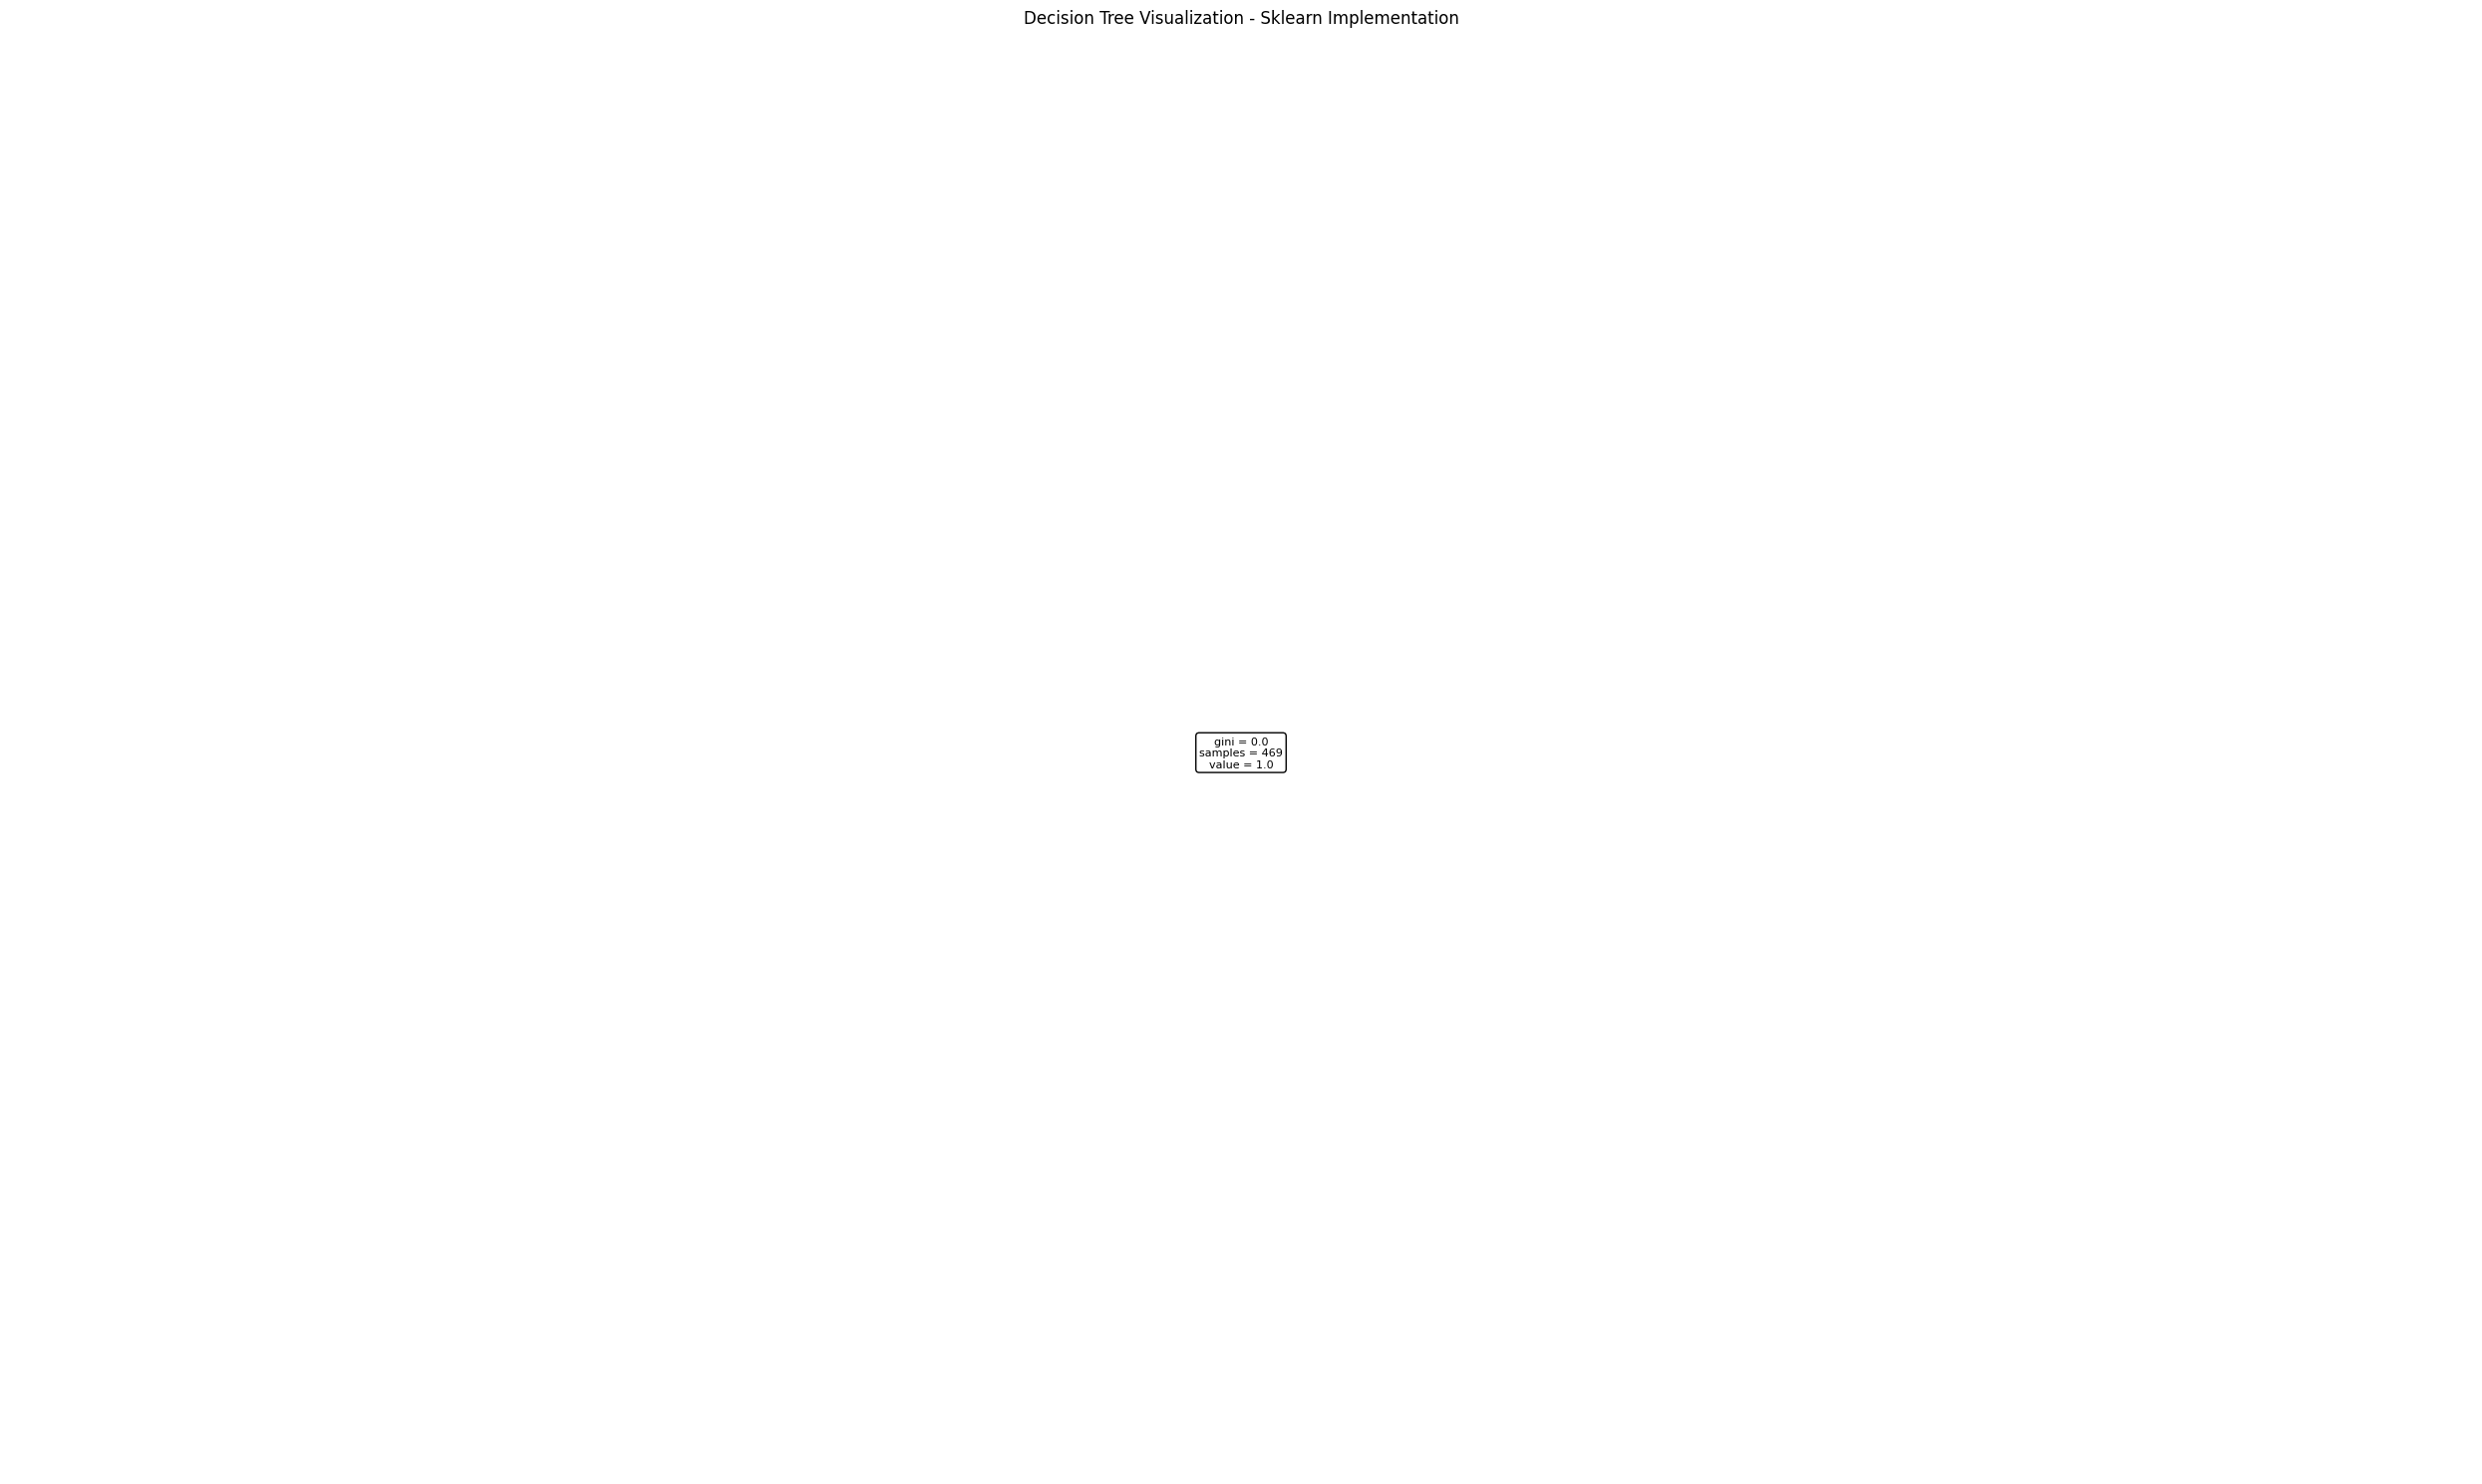

Decision tree visualized with 469 samples and 5 features
Tree depth: 0
Number of leaves: 1

A7. DECISION BOUNDARY VISUALIZATION
------------------------------
Using features: Distance and Quality
Using 312 data points with 1 classes
Class distribution: {'RUM': 312}


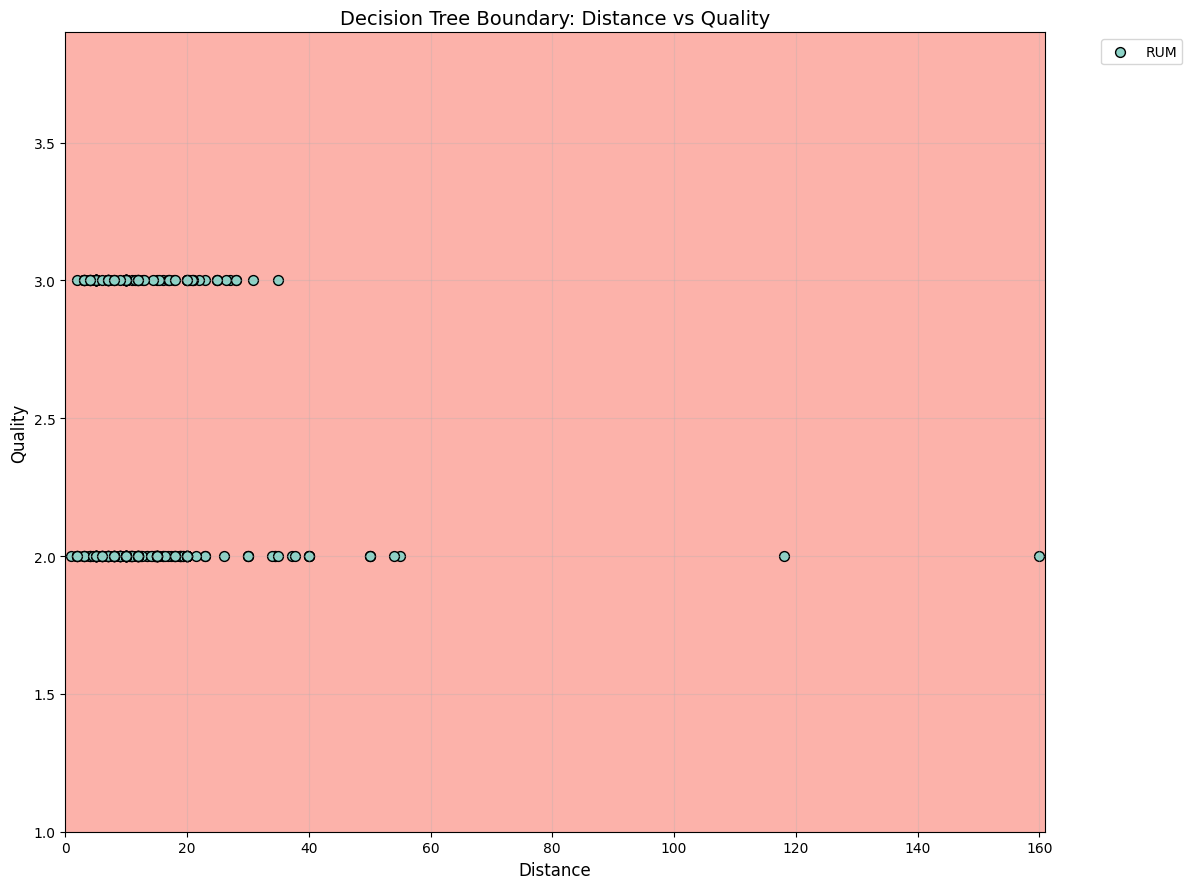

Decision boundary plotted for features: Distance vs Quality
Number of data points: 312
Number of classes: 1

ANALYSIS COMPLETE!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.tree import plot_tree
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

class DecisionTreeLab:
    def __init__(self, data_path):
        """Initialize with dataset"""
        self.df = pd.read_csv(data_path)
        self.prepare_data()
    
    def prepare_data(self):
        """Prepare data for analysis"""
        # Use Call_Type as target variable
        self.target_col = 'Call_Type'
        
        # Remove rows with missing target values and clean target variable
        self.df = self.df.dropna(subset=[self.target_col])
        self.df[self.target_col] = self.df[self.target_col].astype(str).str.strip()
        
        # Remove rows with empty or invalid target values
        self.df = self.df[self.df[self.target_col].str.len() > 0]
        self.df = self.df[self.df[self.target_col] != 'nan']
        
        # Select numerical features for analysis
        numerical_cols = ['Distance', 'Quality', 'CallerAge', 'Elicitor1Age'] + \
                        [col for col in self.df.columns if col.startswith('V') or col.startswith('F') or col.startswith('M')]
        
        # Keep only columns that exist and have sufficient data
        self.numerical_features = [col for col in numerical_cols if col in self.df.columns and self.df[col].notna().sum() > 50]
        
        # Ensure we have numeric data
        for col in self.numerical_features:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
        
        print(f"Dataset shape: {self.df.shape}")
        print(f"Target variable classes: {self.df[self.target_col].value_counts()}")
        print(f"Selected features: {len(self.numerical_features)} numerical features")
        print(f"Sample features: {self.numerical_features[:10]}")
    
    # A1: Calculate Entropy
    def calculate_entropy(self, target_values=None):
        """Calculate entropy for the dataset or given target values"""
        if target_values is None:
            target_values = self.df[self.target_col]
        
        # Get value counts and probabilities
        value_counts = pd.Series(target_values).value_counts()
        total = len(target_values)
        
        if total == 0:
            return 0
        
        entropy = 0
        for count in value_counts:
            if count > 0:
                p_i = count / total
                entropy -= p_i * np.log2(p_i)
        
        return entropy
    
    # A1 (continued): Equal Width Binning for continuous data
    def equal_width_binning(self, data, n_bins=4, bin_type='width'):
        """
        Convert continuous data to categorical using binning
        bin_type: 'width' for equal width, 'frequency' for equal frequency
        """
        if bin_type == 'width':
            bins = pd.cut(data, bins=n_bins, labels=False, duplicates='drop')
        elif bin_type == 'frequency':
            bins = pd.qcut(data, q=n_bins, labels=False, duplicates='drop')
        else:
            raise ValueError("bin_type must be 'width' or 'frequency'")
        
        return bins
    
    # A2: Calculate Gini Index
    def calculate_gini_index(self, target_values=None):
        """Calculate Gini index for the dataset"""
        if target_values is None:
            target_values = self.df[self.target_col]
        
        value_counts = pd.Series(target_values).value_counts()
        total = len(target_values)
        
        if total == 0:
            return 0
        
        gini = 1
        for count in value_counts:
            p_i = count / total
            gini -= p_i ** 2
        
        return gini
    
    # A3: Information Gain calculation
    def calculate_information_gain(self, feature_values, target_values):
        """Calculate information gain for a feature"""
        # Calculate entropy of the entire dataset
        total_entropy = self.calculate_entropy(target_values)
        
        # Get unique values and their counts
        unique_values = pd.Series(feature_values).unique()
        total_samples = len(target_values)
        
        weighted_entropy = 0
        for value in unique_values:
            if pd.isna(value):
                continue
            
            # Get subset for this value
            mask = pd.Series(feature_values) == value
            subset_target = pd.Series(target_values)[mask]
            
            if len(subset_target) > 0:
                weight = len(subset_target) / total_samples
                subset_entropy = self.calculate_entropy(subset_target)
                weighted_entropy += weight * subset_entropy
        
        return total_entropy - weighted_entropy
    
    # A3: Find best feature for root node
    def find_best_feature_for_root(self, features=None):
        """Find the best feature for root node using information gain"""
        if features is None:
            features = self.numerical_features[:10]  # Use first 10 features
        
        best_feature = None
        best_gain = -1
        feature_gains = {}
        
        target_values = self.df[self.target_col].values
        
        for feature in features:
            if feature not in self.df.columns:
                continue
                
            feature_data = self.df[feature].dropna()
            if len(feature_data) < 10:  # Skip features with too little data
                continue
            
            # Convert to categorical using binning
            try:
                binned_feature = self.equal_width_binning(feature_data, n_bins=4)
                
                # Align with target values (same indices)
                common_indices = feature_data.index.intersection(self.df.index)
                aligned_feature = binned_feature[feature_data.index.get_indexer(common_indices)]
                aligned_target = self.df.loc[common_indices, self.target_col]
                
                # Calculate information gain
                gain = self.calculate_information_gain(aligned_feature, aligned_target)
                feature_gains[feature] = gain
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    
            except Exception as e:
                print(f"Error processing feature {feature}: {e}")
                continue
        
        return best_feature, best_gain, feature_gains
    
    # A4: Enhanced binning function with overloading simulation
    def advanced_binning(self, data, n_bins=4, bin_type='width', labels=None):
        """
        Enhanced binning function with default parameters
        Simulates function overloading using default parameters
        """
        # Handle default parameters
        if n_bins is None:
            n_bins = 4
        if bin_type is None:
            bin_type = 'width'
        
        # Remove NaN values
        clean_data = pd.Series(data).dropna()
        
        if len(clean_data) == 0:
            return pd.Series([])
        
        try:
            if bin_type == 'width':
                if labels is None:
                    binned = pd.cut(clean_data, bins=n_bins, labels=False, duplicates='drop')
                else:
                    binned = pd.cut(clean_data, bins=n_bins, labels=labels, duplicates='drop')
            elif bin_type == 'frequency':
                if labels is None:
                    binned = pd.qcut(clean_data, q=n_bins, labels=False, duplicates='drop')
                else:
                    binned = pd.qcut(clean_data, q=n_bins, labels=labels, duplicates='drop')
            else:
                raise ValueError("bin_type must be 'width' or 'frequency'")
            
            return binned
        except Exception as e:
            print(f"Binning error: {e}")
            return pd.cut(clean_data, bins=2, labels=False, duplicates='drop')
    
    # A5: Simple Decision Tree Implementation
    class SimpleDecisionTree:
        def __init__(self, max_depth=3, min_samples_split=10):
            self.max_depth = max_depth
            self.min_samples_split = min_samples_split
            self.tree = None
        
        def fit(self, X, y, parent_instance):
            """Build the decision tree"""
            self.parent = parent_instance
            self.tree = self._build_tree(X, y, depth=0)
        
        def _build_tree(self, X, y, depth):
            """Recursively build the decision tree"""
            # Base cases
            if depth >= self.max_depth or len(y) < self.min_samples_split:
                return {'prediction': pd.Series(y).mode().iloc[0] if len(y) > 0 else 'unknown'}
            
            if len(pd.Series(y).unique()) == 1:
                return {'prediction': y.iloc[0] if hasattr(y, 'iloc') else y[0]}
            
            # Find best split
            best_feature = None
            best_gain = -1
            
            for feature in X.columns:
                feature_data = X[feature].dropna()
                if len(feature_data) < 5:
                    continue
                
                try:
                    binned_feature = self.parent.advanced_binning(feature_data, n_bins=3)
                    if len(binned_feature.unique()) > 1:
                        gain = self.parent.calculate_information_gain(binned_feature, y[feature_data.index])
                        if gain > best_gain:
                            best_gain = gain
                            best_feature = feature
                except:
                    continue
            
            if best_feature is None:
                return {'prediction': pd.Series(y).mode().iloc[0] if len(y) > 0 else 'unknown'}
            
            # Create node
            node = {'feature': best_feature, 'children': {}}
            
            # Split data
            feature_data = X[best_feature]
            binned_feature = self.parent.advanced_binning(feature_data, n_bins=3)
            
            for bin_value in binned_feature.unique():
                if pd.isna(bin_value):
                    continue
                
                mask = binned_feature == bin_value
                X_subset = X[mask]
                y_subset = y[mask]
                
                if len(y_subset) > 0:
                    node['children'][bin_value] = self._build_tree(X_subset, y_subset, depth + 1)
            
            return node
        
        def predict(self, X):
            """Make predictions"""
            predictions = []
            for idx in range(len(X)):
                pred = self._predict_single(X.iloc[idx], self.tree)
                predictions.append(pred)
            return predictions
        
        def _predict_single(self, sample, node):
            """Predict single sample"""
            if 'prediction' in node:
                return node['prediction']
            
            feature = node['feature']
            feature_value = sample[feature]
            
            if pd.isna(feature_value):
                # Return most common prediction from children
                all_predictions = []
                for child in node['children'].values():
                    if 'prediction' in child:
                        all_predictions.append(child['prediction'])
                return max(set(all_predictions), key=all_predictions.count) if all_predictions else 'unknown'
            
            # Find appropriate bin
            binned_value = self.parent.advanced_binning([feature_value], n_bins=3).iloc[0]
            
            if binned_value in node['children']:
                return self._predict_single(sample, node['children'][binned_value])
            else:
                return 'unknown'
    
    def build_decision_tree(self):
        """Build custom decision tree"""
        # Prepare data
        features_to_use = self.numerical_features[:8]  # Use first 8 features
        X = self.df[features_to_use].copy()
        y = self.df[self.target_col].copy()
        
        # Remove rows with all NaN features
        valid_rows = X.notna().any(axis=1) & y.notna()
        X = X[valid_rows]
        y = y[valid_rows]
        
        # Build tree
        self.custom_tree = self.SimpleDecisionTree(max_depth=3, min_samples_split=20)
        self.custom_tree.fit(X, y, self)
        
        return self.custom_tree
    
    # A6: Visualize Decision Tree
    def visualize_sklearn_tree(self):
        """Create and visualize sklearn decision tree for comparison"""
        # Prepare data with better feature selection
        features_to_use = self.numerical_features[:5]
        X = self.df[features_to_use].copy()
        y = self.df[self.target_col].copy()
        
        # Handle missing values more aggressively
        X = X.fillna(X.median())
        
        # Ensure we have valid target values
        valid_mask = y.notna() & (y.str.len() > 0)
        X = X[valid_mask]
        y = y[valid_mask]
        
        # Remove any remaining invalid entries
        X = X.dropna()
        y = y[X.index]
        
        if len(X) == 0:
            print("No valid data for visualization")
            return None, None, None
        
        print(f"Using {len(X)} samples for tree visualization")
        print(f"Target distribution: {y.value_counts().to_dict()}")
        
        # Create sklearn tree with less restrictive parameters
        clf = tree.DecisionTreeClassifier(
            max_depth=4, 
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            criterion='gini'
        )
        clf.fit(X, y)
        
        # Plot tree
        plt.figure(figsize=(25, 15))
        plot_tree(clf, 
                 feature_names=features_to_use,
                 class_names=clf.classes_,
                 filled=True,
                 rounded=True,
                 fontsize=8,
                 max_depth=3)
        plt.title('Decision Tree Visualization - Sklearn Implementation')
        plt.tight_layout()
        plt.show()
        
        return clf, X, y
    
    # A7: Decision Boundary Visualization
    def visualize_decision_boundary(self, feature1=None, feature2=None):
        """Visualize decision boundary for 2D classification"""
        try:
            if feature1 is None or feature2 is None:
                # Select two best features with good variance
                available_features = []
                for f in self.numerical_features[:15]:
                    if f in self.df.columns:
                        feature_data = pd.to_numeric(self.df[f], errors='coerce').dropna()
                        if len(feature_data) > 50 and feature_data.std() > 0:
                            available_features.append(f)
                
                if len(available_features) < 2:
                    print("Not enough suitable features for boundary visualization")
                    return None, None, None
                
                feature1, feature2 = available_features[0], available_features[1]
            
            print(f"Using features: {feature1} and {feature2}")
            
            # Prepare data with better cleaning
            subset_df = self.df[[feature1, feature2, self.target_col]].copy()
            
            # Convert features to numeric
            subset_df[feature1] = pd.to_numeric(subset_df[feature1], errors='coerce')
            subset_df[feature2] = pd.to_numeric(subset_df[feature2], errors='coerce')
            
            # Clean target variable
            subset_df[self.target_col] = subset_df[self.target_col].astype(str).str.strip()
            
            # Remove invalid entries
            subset_df = subset_df.dropna()
            subset_df = subset_df[subset_df[self.target_col].str.len() > 0]
            subset_df = subset_df[subset_df[self.target_col] != 'nan']
            
            if len(subset_df) < 20:
                print(f"Not enough valid data points ({len(subset_df)}). Need at least 20.")
                return None, None, None
            
            # Keep only classes with sufficient samples
            class_counts = subset_df[self.target_col].value_counts()
            valid_classes = class_counts[class_counts >= 5].index
            subset_df = subset_df[subset_df[self.target_col].isin(valid_classes)]
            
            print(f"Using {len(subset_df)} data points with {len(valid_classes)} classes")
            print(f"Class distribution: {subset_df[self.target_col].value_counts().to_dict()}")
            
            X = subset_df[[feature1, feature2]].values
            y = subset_df[self.target_col].values
            
            # Train classifier
            clf = tree.DecisionTreeClassifier(
                max_depth=4, 
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42
            )
            clf.fit(X, y)
            
            # Create mesh for decision boundary
            h = 0.1  # step size in mesh
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            
            # Make mesh coarser to avoid memory issues
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                np.arange(y_min, y_max, h))
            
            # Make predictions on mesh
            mesh_points = np.c_[xx.ravel(), yy.ravel()]
            
            # Handle potential issues with prediction
            try:
                Z = clf.predict(mesh_points)
                Z = Z.reshape(xx.shape)
            except Exception as e:
                print(f"Error in mesh prediction: {e}")
                # Fallback: use a simpler mesh
                h = h * 2
                xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                    np.arange(y_min, y_max, h))
                mesh_points = np.c_[xx.ravel(), yy.ravel()]
                Z = clf.predict(mesh_points)
                Z = Z.reshape(xx.shape)
            
            # Plot
            plt.figure(figsize=(12, 9))
            
            # Create a color map for classes
            unique_classes = np.unique(y)
            colors = plt.cm.Set3(np.linspace(0, 1, len(unique_classes)))
            class_to_color = {cls: i for i, cls in enumerate(unique_classes)}
            
            # Plot decision boundary
            Z_numeric = np.array([class_to_color[cls] for cls in Z.ravel()]).reshape(Z.shape)
            plt.contourf(xx, yy, Z_numeric, alpha=0.6, levels=len(unique_classes)-1, cmap=plt.cm.Set3)
            
            # Plot data points
            for i, cls in enumerate(unique_classes):
                mask = y == cls
                plt.scatter(X[mask, 0], X[mask, 1], 
                           c=[colors[i]], label=str(cls), 
                           edgecolors='black', s=50)
            
            plt.xlabel(feature1, fontsize=12)
            plt.ylabel(feature2, fontsize=12)
            plt.title(f'Decision Tree Boundary: {feature1} vs {feature2}', fontsize=14)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return clf, subset_df[[feature1, feature2]], subset_df[self.target_col]
            
        except Exception as e:
            print(f"Error in decision boundary visualization: {e}")
            print("Trying with a simpler approach...")
            
            # Fallback approach
            return self.simple_boundary_plot()
    
    def simple_boundary_plot(self):
        """Simple fallback boundary visualization"""
        try:
            # Use just first two numerical features
            if len(self.numerical_features) < 2:
                return None, None, None
                
            feature1, feature2 = self.numerical_features[0], self.numerical_features[1]
            
            # Get clean subset
            data_clean = self.df[[feature1, feature2, self.target_col]].dropna()
            data_clean = data_clean.head(100)  # Use only first 100 samples
            
            if len(data_clean) < 10:
                print("Not enough data for simple boundary plot")
                return None, None, None
            
            X = data_clean[[feature1, feature2]]
            y = data_clean[self.target_col]
            
            # Simple scatter plot with classes
            plt.figure(figsize=(10, 8))
            
            unique_classes = y.unique()
            colors = ['red', 'blue', 'green', 'purple', 'orange']
            
            for i, cls in enumerate(unique_classes[:5]):  # Max 5 classes
                mask = y == cls
                color = colors[i % len(colors)]
                plt.scatter(X[mask][feature1], X[mask][feature2], 
                           c=color, label=str(cls), alpha=0.7, s=50)
            
            plt.xlabel(feature1)
            plt.ylabel(feature2)
            plt.title(f'Feature Space: {feature1} vs {feature2}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return None, X, y
            
        except Exception as e:
            print(f"Error in simple boundary plot: {e}")
            return None, None, None
    
    def run_all_analyses(self):
        """Run all analyses A1-A7"""
        print("="*60)
        print("DECISION TREE LAB - COMPLETE ANALYSIS")
        print("="*60)
        
        # A1: Entropy calculation
        print("\nA1. ENTROPY CALCULATION")
        print("-" * 30)
        entropy = self.calculate_entropy()
        print(f"Dataset Entropy: {entropy:.4f}")
        
        # Example with binning for continuous data
        if len(self.numerical_features) > 0:
            sample_feature = self.numerical_features[0]
            feature_data = self.df[sample_feature].dropna()
            if len(feature_data) > 0:
                binned_data = self.equal_width_binning(feature_data, n_bins=4)
                print(f"Example - {sample_feature} after binning: {binned_data.value_counts().to_dict()}")
        
        # A2: Gini Index
        print("\nA2. GINI INDEX CALCULATION")
        print("-" * 30)
        gini = self.calculate_gini_index()
        print(f"Dataset Gini Index: {gini:.4f}")
        
        # A3: Best feature for root node
        print("\nA3. BEST FEATURE FOR ROOT NODE")
        print("-" * 30)
        best_feature, best_gain, all_gains = self.find_best_feature_for_root()
        print(f"Best feature for root: {best_feature}")
        print(f"Information gain: {best_gain:.4f}")
        print("Top 5 features by information gain:")
        sorted_gains = sorted(all_gains.items(), key=lambda x: x[1], reverse=True)[:5]
        for feat, gain in sorted_gains:
            print(f"  {feat}: {gain:.4f}")
        
        # A4: Advanced binning demonstration
        print("\nA4. ADVANCED BINNING DEMONSTRATION")
        print("-" * 30)
        if len(self.numerical_features) > 0:
            sample_feature = self.numerical_features[0]
            feature_data = self.df[sample_feature].dropna()[:100]  # Use first 100 samples
            
            # Equal width binning
            width_bins = self.advanced_binning(feature_data, n_bins=4, bin_type='width')
            print(f"Equal width binning (4 bins): {width_bins.value_counts().to_dict()}")
            
            # Equal frequency binning
            freq_bins = self.advanced_binning(feature_data, n_bins=4, bin_type='frequency')
            print(f"Equal frequency binning (4 bins): {freq_bins.value_counts().to_dict()}")
        
        # A5: Build custom decision tree
        print("\nA5. CUSTOM DECISION TREE")
        print("-" * 30)
        try:
            custom_tree = self.build_decision_tree()
            print("Custom decision tree built successfully!")
            print("Tree structure (first level):")
            if hasattr(custom_tree, 'tree') and custom_tree.tree:
                print(f"Root feature: {custom_tree.tree.get('feature', 'None')}")
                if 'children' in custom_tree.tree:
                    print(f"Number of branches: {len(custom_tree.tree['children'])}")
        except Exception as e:
            print(f"Error building custom tree: {e}")
        
        # A6: Visualize decision tree
        print("\nA6. DECISION TREE VISUALIZATION")
        print("-" * 30)
        try:
            clf, X, y = self.visualize_sklearn_tree()
            if clf is not None:
                print(f"Decision tree visualized with {len(X)} samples and {X.shape[1]} features")
                print(f"Tree depth: {clf.tree_.max_depth}")
                print(f"Number of leaves: {clf.tree_.n_leaves}")
        except Exception as e:
            print(f"Error in tree visualization: {e}")
        
        # A7: Decision boundary visualization
        print("\nA7. DECISION BOUNDARY VISUALIZATION")
        print("-" * 30)
        try:
            clf_2d, X_2d, y_2d = self.visualize_decision_boundary()
            if clf_2d is not None:
                feature1, feature2 = X_2d.columns[0], X_2d.columns[1]
                print(f"Decision boundary plotted for features: {feature1} vs {feature2}")
                print(f"Number of data points: {len(X_2d)}")
                print(f"Number of classes: {len(y_2d.unique())}")
            else:
                print("Decision boundary visualization completed (may be simplified due to data constraints)")
        except Exception as e:
            print(f"Error in boundary visualization: {e}")
            print("This is often due to data type issues or insufficient class separation.")
        
        print("\n" + "="*60)
        print("ANALYSIS COMPLETE!")
        print("="*60)

# Usage Example
if __name__ == "__main__":
    # Initialize the lab with your dataset
    lab = DecisionTreeLab('20231225_dfall_obs_data_and_spectral_features_revision1_n469.csv')
    
    # Run all analyses
    lab.run_all_analyses()
    
    # entropy = lab.calculate_entropy()
    # gini = lab.calculate_gini_index()
    # best_feature, gain, all_gains = lab.find_best_feature_for_root()
    # custom_tree = lab.build_decision_tree()
    # clf, X, y = lab.visualize_sklearn_tree()
    # clf_2d, X_2d, y_2d = lab.visualize_decision_boundary()